# Dataset Analysis

### Dataset: https://www.yelp.com/dataset

### Documentation: https://www.yelp.com/dataset/documentation/main



In [3]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 833.3 kB/s eta 0:00:00 0:00:01m


In [4]:
# importing necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter

### Data Sampling

In [7]:
# Loading the business and review data
business_file = 'yelp_dataset/yelp_academic_dataset_business.json'
review_file = 'yelp_dataset/yelp_academic_dataset_review.json'

In [8]:
# Load the business data from the JSON file into a DataFrame
business_data = pd.read_json(business_file, lines=True)

Metropolitan Area Chosen: Idaho

In [9]:
# Filter businesses located in Idaho
idaho_businesses = business_data[business_data['state'] == 'ID']

In [10]:
def filter_reviews_for_business_ids(review_file, business_ids):
    chunksize = 100000  # Process 100,000 reviews at a time
    filtered_reviews = []
    
    with pd.read_json(review_file, lines=True, chunksize=chunksize) as reader:
        for chunk in reader:
            # Filter reviews where business_id is in the Idaho business list
            filtered_chunk = chunk[chunk['business_id'].isin(business_ids)]
            filtered_reviews.append(filtered_chunk)
    
    # Concatenate all filtered chunks
    return pd.concat(filtered_reviews, ignore_index=True)

In [11]:
# Get list of business_ids for Idaho businesses
idaho_business_ids = idaho_businesses['business_id'].tolist()

In [12]:
# Filter reviews for Idaho businesses
idaho_reviews = filter_reviews_for_business_ids(review_file, idaho_business_ids)

In [13]:
# Combine Idaho Business and Review Data
idaho_data = pd.merge(idaho_reviews, idaho_businesses, on='business_id', how='inner')
idaho_data.rename(columns={'stars_x': 'review_rating', 'stars_y': 'business_rating'}, inplace=True)

In [14]:
# Save the idaho_data DataFrame to a new CSV file
idaho_data.to_csv('idaho_combined_data.csv', index=False)

print("Idaho data has been saved to 'idaho_combined_data.csv'.")

Idaho data has been saved to 'idaho_combined_data.csv'.


In [15]:
# Load the combined data from the CSV file
idaho_data = pd.read_csv('idaho_combined_data.csv')

In [18]:
idaho_data.head()

,review_id,user_id,business_id,review_rating,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,business_rating,review_count,is_open,attributes,categories,hours
0,Lk21QNbrI_e3nf0GvWSPww,bCla27ma_6i_QFrGkILKrQ,sLgnx_WFCjEoPsS6NwU70Q,5,0,0,0,Our family returned for breakfast again this w...,2014-10-27 16:31:37,Le Peep,...,ID,83646,43.632783,-116.352393,4.0,259,1,"{'WheelchairAccessible': 'True', 'BusinessPark...","Event Planning & Services, Salad, Caterers, Am...","{'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ..."
1,r1tPwFMILy0COeEQ-B3YLw,3M1_pyDSgMP6sRMz564eJw,8xM8akbQhHDQdJO1sPMB1A,5,0,0,0,I had the pleasure to meet with Ann today and ...,2018-07-26 09:15:30,Black Rock Coffee Bar,...,ID,83704,43.619175,-116.280731,4.5,7,1,"{'WiFi': ""'free'"", 'RestaurantsPriceRange2': '...","Coffee & Tea, Food","{'Monday': '0:0-0:0', 'Tuesday': '5:0-21:0', '..."
2,rHrhsfMGmYfCGiN8Ul02qQ,x67HAnA_-ukgw9qwyMVOhQ,Cu8ysHKiZmJKRY9nF3Hzsw,5,0,0,0,"These guys do good work, on time, and warranty...",2016-10-26 15:25:30,Perfect Plumbing Heating & Air,...,ID,83714,43.632087,-116.249465,3.5,83,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Heating & Air Conditioning/HVAC, Water Heater ...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
3,BiETNEHMCcmUWQDJMHQQqA,GNPPfbW6VzB3wjo5vPO5ug,kgeiJzWSiXPnf-3wx7LHIQ,3,0,0,0,"Three stars not because of food, the food is g...",2017-01-28 01:42:58,Panera Bread,...,ID,83646,43.636106,-116.354792,3.0,81,1,"{'Alcohol': ""'none'"", 'NoiseLevel': ""u'average...","Sandwiches, Salad, Soup, Restaurants","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,IWflChcWypgf2Vlsm1WT5A,q3NoRGSIqKxdrmzNzURXeQ,4FaYG9qKDpDyr68bKmaIEw,5,0,0,0,My husband took me here for our Anniversary an...,2018-02-02 02:16:19,Capitol Cellars,...,ID,83702,43.613573,-116.199904,4.0,176,1,"{'Smoking': ""u'no'"", 'RestaurantsGoodForGroups...","Restaurants, Bars, Wine Bars, American (Tradit...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-21:0',..."


In [11]:
# Basic statistics about Idaho businesses and reviews
total_businesses = idaho_data['business_id'].nunique()  # Unique businesses
total_reviews = idaho_data.shape[0]  # Total number of reviews

# Average business rating (from the original business rating)
average_business_rating = idaho_data['business_rating'].mean()
# Average review rating (from the review ratings)
average_review_rating = idaho_data['review_rating'].mean()

# Average review length (in characters)
average_review_length = idaho_data['text'].apply(len).mean()  # Assuming 'text' contains the review content

# Number of reviews per business
reviews_per_business = idaho_data.groupby('business_id')['text'].count()

# Average and max/min reviews per business
average_reviews_per_business = reviews_per_business.mean()
max_reviews_per_business = reviews_per_business.max()
min_reviews_per_business = reviews_per_business.min()

# Print the statistics
print(f"Total number of unique businesses in Idaho: {total_businesses}")
print(f"Total number of reviews for Idaho businesses: {total_reviews}")
print(f"Average business rating in Idaho: {average_business_rating:.2f}")
print(f"Average review length (in characters): {average_review_length:.2f}")
print(f"Average number of reviews per business: {average_reviews_per_business:.0f}")
print(f"Maximum reviews for a business: {max_reviews_per_business}")
print(f"Minimum reviews for a business: {min_reviews_per_business}")

Total number of unique businesses in Idaho: 4467
Total number of reviews for Idaho businesses: 157572
Average business rating in Idaho: 3.76
Average review length (in characters): 537.98
Average number of reviews per business: 35
Maximum reviews for a business: 1872
Minimum reviews for a business: 5


### Tokenization and Stemming

In [16]:
# Downloading required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guocheng/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/guocheng/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
# Random Business Selection
random_businesses = idaho_data['business_id'].sample(2, random_state=1).tolist()
b1, b2 = random_businesses

In [26]:
b1, b2 #= ('hs2LaDxJLgqGuDq3dyiQhQ', '7AkkPs8k-GApX8BwN1es7A')

('hs2LaDxJLgqGuDq3dyiQhQ', '7AkkPs8k-GApX8BwN1es7A')

In [30]:
# Print Business Names
B1_name = idaho_businesses[idaho_businesses['business_id'] == b1]
B2_name = idaho_businesses[idaho_businesses['business_id'] == b2]

#pd.concat([B1_name, B2_name])
B1_name.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
37247,hs2LaDxJLgqGuDq3dyiQhQ,Bliss Events,,Boise,ID,83702,43.662439,-116.163043,4.5,17,1,{'BusinessAcceptsCreditCards': 'True'},"Party & Event Planning, Event Planning & Servi...","{'Tuesday': '10:0-15:0', 'Wednesday': '10:0-15..."


In [32]:
# Extract reviews for B1 and B2
B1_reviews = idaho_data[idaho_data['business_id'] == b1]['text']
B2_reviews = idaho_data[idaho_data['business_id'] == b2]['text']

In [33]:
# Function to remove stopwords only (no stemming)
def remove_stopwords(reviews):
    stop_words = set(stopwords.words('english'))  # Stopword list
    filtered_reviews = []
    for review in reviews:
        # Tokenization
        tokens = word_tokenize(review.lower())  # Lowercase and tokenize
        # Remove stopwords and non-alphabetic tokens
        filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
        filtered_reviews.append(filtered_tokens)
    return filtered_reviews

# Function to tokenize, remove stopwords, and apply stemming
def preprocess_reviews(reviews):
    ps = PorterStemmer()  # Initializing the stemming algorithm
    stop_words = set(stopwords.words('english'))  # List of English stopwords for removal

    tokenized_reviews = []
    for review in reviews:
        tokens = word_tokenize(review.lower())  # Convert to lowercase and tokenize
        filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]  # Keep only alphabetic tokens
        stemmed_tokens = [ps.stem(word) for word in filtered_tokens]  # Apply stemming
        tokenized_reviews.append(stemmed_tokens)
    return tokenized_reviews

In [34]:
# Remove stopwords only (for B1 and B2)
B1 = remove_stopwords(B1_reviews)
B2 = remove_stopwords(B2_reviews)

# Tokenization, stopword removal, and stemming (for B1_processed and B2_processed)
B1_processed = preprocess_reviews(B1_reviews)
B2_processed = preprocess_reviews(B2_reviews)

In [35]:
B1_rev_lengths = [len(review) for review in B1]
B2_rev_lengths = [len(review) for review in B2]

B1_avg_rev = sum(B1_rev_lengths)/len(B1_rev_lengths)
B2_avg_rev = sum(B2_rev_lengths)/len(B2_rev_lengths)

In [36]:
B1_avg_rev, B2_avg_rev

(145.11764705882354, 44.768)

In [37]:
# Calculate word frequency 
def calculate_word_frequency(reviews):
    all_words = [word for review in reviews for word in review]  # Flatten the processed reviews
    return Counter(all_words)  # Count word frequencies

# Calculate word frequencies for B1 and B2 before stemming
B1_word_freq_before = calculate_word_frequency(B1)
B2_word_freq_before = calculate_word_frequency(B2)

# Calculate word frequencies for B1 and B2 after stemming
B1_word_freq_after = calculate_word_frequency(B1_processed)
B2_word_freq_after = calculate_word_frequency(B2_processed)

/var/folders/ys/njs5n_kj34q1z3fs8ww_j3640000gn/T/ipykernel_5206/2060352932.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words_B1, rotation=45, ha='right')
/var/folders/ys/njs5n_kj34q1z3fs8ww_j3640000gn/T/ipykernel_5206/2060352932.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(words_B2, rotation=45, ha='right')


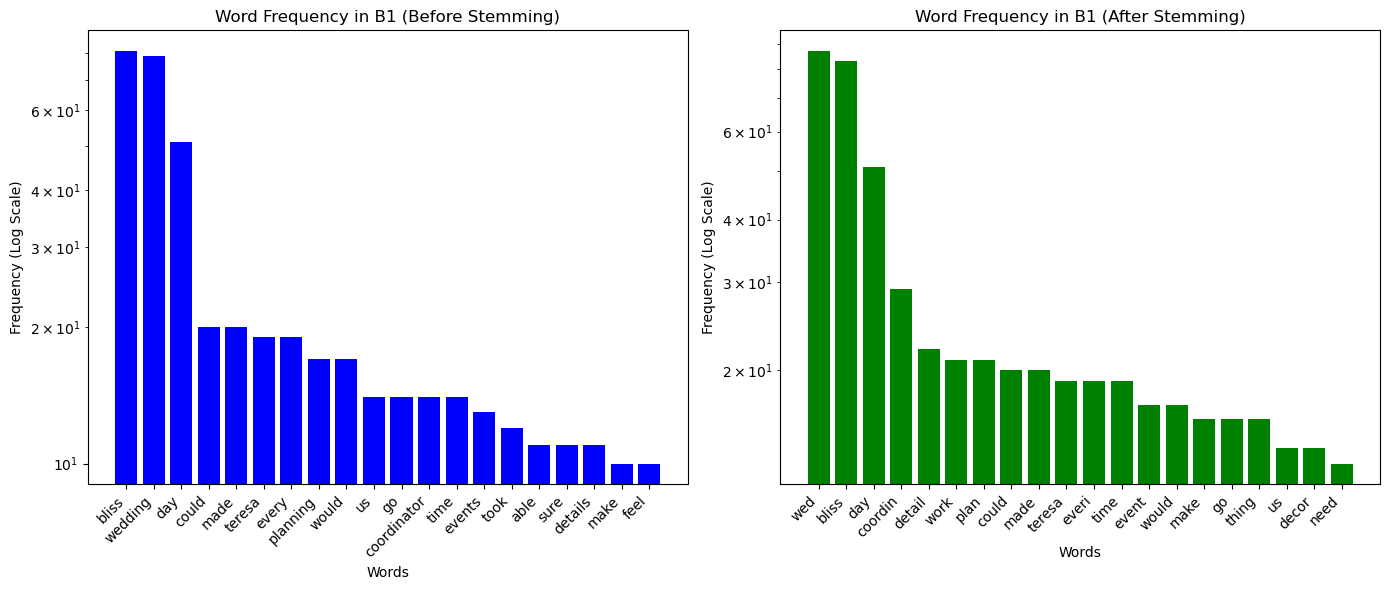

/var/folders/ys/njs5n_kj34q1z3fs8ww_j3640000gn/T/ipykernel_5206/2060352932.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(words_B1, rotation=45, ha='right')
/var/folders/ys/njs5n_kj34q1z3fs8ww_j3640000gn/T/ipykernel_5206/2060352932.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(words_B2, rotation=45, ha='right')


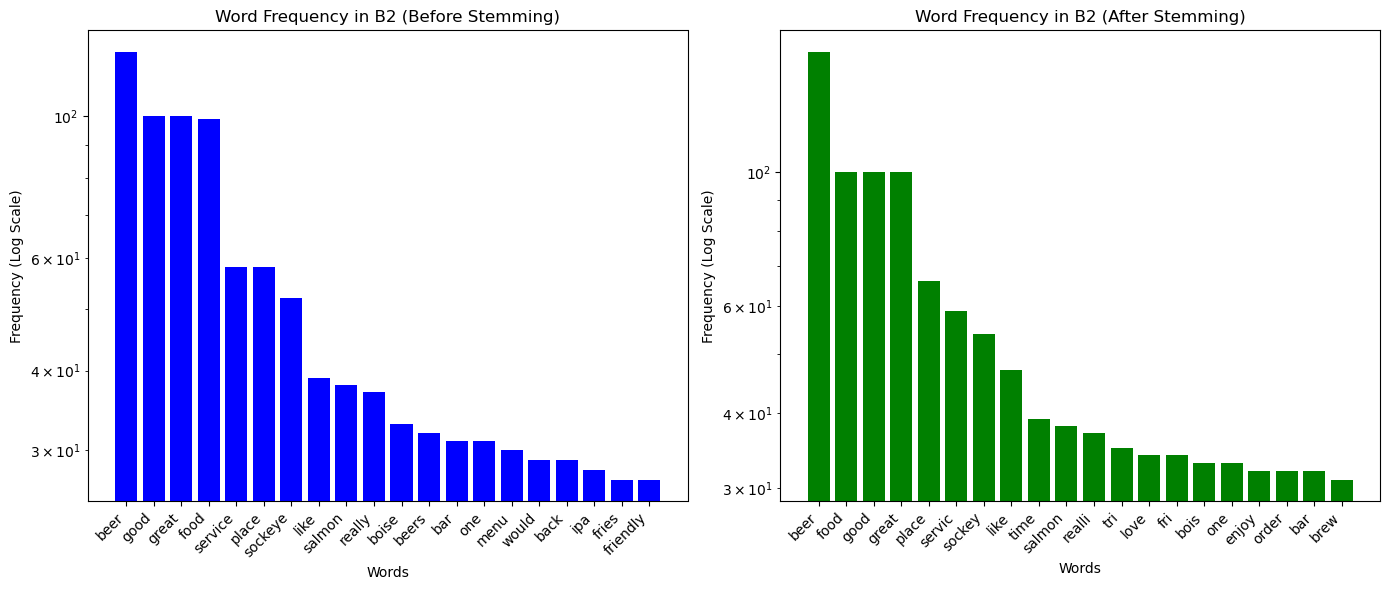

In [38]:
import matplotlib.pyplot as plt

# Function to plot word frequency distribution side by side for B1 and B2
def plot_word_freq_side_by_side(word_freq_B1, word_freq_B2, title_B1, title_B2, color_before='blue', color_after='green'):
    # Sort word frequencies in descending order (Top 20 words)
    sorted_word_freq_B1 = word_freq_B1.most_common(20)
    sorted_word_freq_B2 = word_freq_B2.most_common(20)
    
    words_B1, freqs_B1 = zip(*sorted_word_freq_B1)
    words_B2, freqs_B2 = zip(*sorted_word_freq_B2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Two side-by-side plots

    # Plot for B1 (Before Stemming)
    axes[0].bar(words_B1, freqs_B1, color=color_before)
    axes[0].set_yscale('log')  # Set y-axis to log scale
    axes[0].set_xticklabels(words_B1, rotation=45, ha='right')
    axes[0].set_title(title_B1)
    axes[0].set_xlabel('Words')
    axes[0].set_ylabel('Frequency (Log Scale)')

    # Plot for B2 (After Stemming)
    axes[1].bar(words_B2, freqs_B2, color=color_after)
    axes[1].set_yscale('log')  # Set y-axis to log scale
    axes[1].set_xticklabels(words_B2, rotation=45, ha='right')
    axes[1].set_title(title_B2)
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Frequency (Log Scale)')

    plt.tight_layout()
    plt.show()

# Plot for B1 before and after stemming
plot_word_freq_side_by_side(B1_word_freq_before, B1_word_freq_after, 
                            "Word Frequency in B1 (Before Stemming)", 
                            "Word Frequency in B1 (After Stemming)", 
                            color_before='blue', color_after='green')

# Plot for B2 before and after stemming
plot_word_freq_side_by_side(B2_word_freq_before, B2_word_freq_after, 
                            "Word Frequency in B2 (Before Stemming)", 
                            "Word Frequency in B2 (After Stemming)", 
                            color_before='blue', color_after='green')


In [39]:
# Display top 10 most frequent words before and after stemming
print("Top 10 most frequent words in B1 before stemming:", B1_word_freq_before.most_common(10), "\n")
print("Top 10 most frequent words in B1 after stemming:", B1_word_freq_after.most_common(10), "\n")
print("Top 10 most frequent words in B2 before stemming:", B2_word_freq_before.most_common(10), "\n")
print("Top 10 most frequent words in B2 after stemming:", B2_word_freq_after.most_common(10), "\n")

Top 10 most frequent words in B1 before stemming: [('bliss', 81), ('wedding', 79), ('day', 51), ('could', 20), ('made', 20), ('teresa', 19), ('every', 19), ('planning', 17), ('would', 17), ('us', 14)] 

Top 10 most frequent words in B1 after stemming: [('wed', 87), ('bliss', 83), ('day', 51), ('coordin', 29), ('detail', 22), ('work', 21), ('plan', 21), ('could', 20), ('made', 20), ('teresa', 19)] 

Top 10 most frequent words in B2 before stemming: [('beer', 126), ('good', 100), ('great', 100), ('food', 99), ('service', 58), ('place', 58), ('sockeye', 52), ('like', 39), ('salmon', 38), ('really', 37)] 

Top 10 most frequent words in B2 after stemming: [('beer', 158), ('food', 100), ('good', 100), ('great', 100), ('place', 66), ('servic', 59), ('sockey', 54), ('like', 47), ('time', 39), ('salmon', 38)] 

